In [11]:
import os
import sys
import glob
import yaml
import pickle
import random

import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, LabelEncoder

import wandb
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.utilities.seed import seed_everything

## config

In [2]:
# config
with open('config.yaml') as f:
    config = yaml.safe_load(f)

# globals variable
SEED = config['globals']['seed']
MAX_EPOCHS = config['globals']['max_epochs']
N_SPLITS = config['globals']['n_splits']
USE_FOLDS = config['globals']['use_folds']
DEBUG = config['globals']['debug']
EXP_MESSAGE = config['globals']['exp_message']
NOTES = config['globals']['notes']
MODEL_SAVE = config['globals']['model_save']
ONLY_PRED = config['globals']['only_pred']
PRETRAINED = config['globals']['pretrained']
PRETRAINED_PATH = config['globals']['pretrained_path']
EXP_NAME = str(Path().resolve()).split('/')[-1]

# seed
seed_everything(SEED)

Global seed set to 1996


1996

In [3]:
EXP_NAME

'exp059'

In [4]:
!wandb login 1bb2d0449c11d8b987e25c38b9d8dda176310fb6

wandb: Appending key for api.wandb.ai to your netrc file: /home/user/.netrc


## read data

In [5]:
# waypointを補正したdataset
root_dir = Path('../../input/')
with open(root_dir/'2kaido_wifi_dataset_v3/train_10000_7.pkl', 'rb') as f:
  train_df = pickle.load(f)

with open(root_dir/'2kaido_wifi_dataset_v3/test_10000_7.pkl', 'rb') as f:
  test_df = pickle.load(f)

sub_df = pd.read_csv(root_dir/'indoor-location-navigation/sample_submission.csv', index_col=0)

In [6]:
train_df = train_df.astype({'timestamp':int,'x': np.float32, 'y': np.float32, 'floor':np.float32, 'ix':np.float32, 'iy':np.float32})
test_df = test_df.astype({'timestamp':int})

In [7]:
train_df = train_df.reset_index().rename(columns={'index':'id'})

<AxesSubplot:>

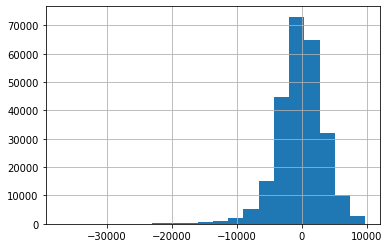

In [8]:
train_df['timediff'].astype(int).hist(bins=20)

In [9]:
train_df

,id,ssid_0,ssid_1,ssid_2,ssid_3,ssid_4,ssid_5,ssid_6,ssid_7,ssid_8,...,y,itimestamp,ix,iy,floor,floor_str,path,site_id,timediff,itimediff
0,0,356d66c73c423be835bd5d07cb1ebdfa821d8e23,c3513a636d1a813db081a2ffc33f297b4fefe28d,990847ae755de95a44c7b1be54e66f4e56fdc7f4,4e601619b7c7d9df8d61490ad2c134f08ea01d61,c3513a636d1a813db081a2ffc33f297b4fefe28d,b14c56d7cd73a5b026fc118c671e24dc2ba2558b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,...,156.842239,1578466134278,113.615387,156.634796,-1.0,B1,5e1580d1f4c3420006d520e4,5a0546857ecc773753327266,-1545,-45
1,1,356d66c73c423be835bd5d07cb1ebdfa821d8e23,f44fa6118fed7198296c8b45b2f2684903d99620,c3513a636d1a813db081a2ffc33f297b4fefe28d,990847ae755de95a44c7b1be54e66f4e56fdc7f4,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,da39a3ee5e6b4b0d3255bfef95601890afd80709,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,...,156.842239,1578466136278,112.655884,156.358200,-1.0,B1,5e1580d1f4c3420006d520e4,5a0546857ecc773753327266,-3512,-12
2,2,f44fa6118fed7198296c8b45b2f2684903d99620,356d66c73c423be835bd5d07cb1ebdfa821d8e23,8aed75f7c344e6a3d4916750029dd4ee47c1e7c5,c3513a636d1a813db081a2ffc33f297b4fefe28d,5a368e0bd5050bdb4653dc39c86bee1fd2b8aeb7,4e601619b7c7d9df8d61490ad2c134f08ea01d61,2ce029b3a3dea973a44bf0587be5e2b93a74e5f1,b14c56d7cd73a5b026fc118c671e24dc2ba2558b,3fa90121039c7b6e24ae985d228e0366ae15fba4,...,156.842239,1578466138278,111.936256,156.150772,-1.0,B1,5e1580d1f4c3420006d520e4,5a0546857ecc773753327266,-5471,29
3,3,356d66c73c423be835bd5d07cb1ebdfa821d8e23,f44fa6118fed7198296c8b45b2f2684903d99620,5a368e0bd5050bdb4653dc39c86bee1fd2b8aeb7,990847ae755de95a44c7b1be54e66f4e56fdc7f4,da39a3ee5e6b4b0d3255bfef95601890afd80709,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,3fa90121039c7b6e24ae985d228e0366ae15fba4,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,...,156.842239,1578466140278,110.976761,155.874176,-1.0,B1,5e1580d1f4c3420006d520e4,5a0546857ecc773753327266,-7428,72
4,4,f44fa6118fed7198296c8b45b2f2684903d99620,356d66c73c423be835bd5d07cb1ebdfa821d8e23,990847ae755de95a44c7b1be54e66f4e56fdc7f4,c3513a636d1a813db081a2ffc33f297b4fefe28d,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,...,154.629517,1578466142278,110.017258,155.597580,-1.0,B1,5e1580d1f4c3420006d520e4,5a0546857ecc773753327266,7401,105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252807,252807,18336f0964fbd470a2ee7116d33b96946c633999,072159287058774aa9b450c9163129b309bc982b,18336f0964fbd470a2ee7116d33b96946c633999,040667e2fdd3a9bbb54e970c430ad6f08416c52e,072159287058774aa9b450c9163129b309bc982b,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,...,107.011642,1573892866000,128.925217,109.018059,6.0,F7,5dcfb393878f3300066c70a6,5dc8cea7659e181adb076a3f,-2224,38
252808,252808,18336f0964fbd470a2ee7116d33b96946c633999,18336f0964fbd470a2ee7116d33b96946c633999,072159287058774aa9b450c9163129b309bc982b,072159287058774aa9b450c9163129b309bc982b,ea9e102c49dbc834b1059c5e8b5dc4a017a82dff,040667e2fdd3a9bbb54e970c430ad6f08416c52e,da39a3ee5e6b4b0d3255bfef95601890afd80709,ea9e102c49dbc834b1059c5e8b5dc4a017a82dff,da39a3ee5e6b4b0d3255bfef95601890afd80709,...,111.526085,1573892868000,130.645798,110.522873,6.0,F7,5dcfb393878f3300066c70a6,5dc8cea7659e181adb076a3f,1098,126
252809,252809,18336f0964fbd470a2ee7116d33b96946c633999,18336f0964fbd470a2ee7116d33b96946c633999,072159287058774aa9b450c9163129b309bc982b,ea9e102c49dbc834b1059c5e8b5dc4a017a82dff,072159287058774aa9b450c9163129b309bc982b,040667e2fdd3a9bbb54e970c430ad6f08416c52e,1f09251bbfadafb11c63c87963af25238d6bc886,da39a3ee5e6b4b0d

In [10]:
test_df

,ssid_0,ssid_1,ssid_2,ssid_3,ssid_4,ssid_5,ssid_6,ssid_7,ssid_8,ssid_9,...,timediff_96,timediff_97,timediff_98,timediff_99,timestamp,real_timestamp,path,site_id,timediff,site_path_timestamp
0,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,ab150ecf6d972b476aeab16317bed6189d9f7cce,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,7182afc4e5c212133d5d7d76eb3df6c24618302b,da39a3ee5e6b4b0d3255bfef95601890afd80709,01e78c97f2c04cdbc7c4159158bb125a9bb558ff,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,7182afc4e5c212133d5d7d76eb3df6c24618302b,...,1251.0,1228.0,877.0,135.0,9,1578474564146,046cfa46be49fc10834815c6,5a0546857ecc773753327266,-2331,5a0546857ecc773753327266_046cfa46be49fc1083481...
1,7182afc4e5c212133d5d7d76eb3df6c24618302b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,da39a3ee5e6b4b0d3255bfef95601890afd80709,b7e6027447eb1f81327d66cfd3adbe557aabf26c,...,5532.0,5529.0,5532.0,5350.0,9017,1578474573154,046cfa46be49fc10834815c6,5a0546857ecc773753327266,4287,5a0546857ecc773753327266_046cfa46be49fc1083481...
2,da39a3ee5e6b4b0d3255bfef95601890afd80709,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,7182afc4e5c212133d5d7d76eb3df6c24618302b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,...,859.0,853.0,5739.0,3633.0,9017,1578474573154,046cfa46be49fc10834815c6,5a0546857ecc773753327266,-491,5a0546857ecc773753327266_046cfa46be49fc1083481...
3,7182afc4e5c212133d5d7d76eb3df6c24618302b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,da39a3ee5e6b4b0d3255bfef95601890afd80709,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,...,5741.0,2950.0,2949.0,2951.0,9017,1578474573154,046cfa46be49fc10834815c6,5a0546857ecc773753327266,1827,5a0546857ecc773753327266_046cfa46be49fc1083481...
4,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,da39a3ee5e6b4b0d3255bfef95601890afd80709,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,da39a3ee5e6b4b0d3255bfef95601890afd80709,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,...,7649.0,7373.0,1883.0,1422.0,15326,1578474579463,046cfa46be49fc10834815c6,5a0546857ecc773753327266,612,5a0546857ecc773753327266_046cfa46be49fc1083481...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37434,8e69018f6343506344ab13646ccd9447fc2ffb19,8e69018f6343506344ab13646ccd9447fc2ffb19,5d998a8668536c4f51004c25f474117fe9555f78,da39a3ee5e6b4b0d3255bfef95601890afd80709,5d998a8668536c4f51004c25f474117fe9555f78,5d998a8668536c4f51004c25f474117fe9555f78,5d998a8668536c4f51004c25f474117fe9555f78,da39a3ee5e6b4b0d3255bfef95601890afd80709,0f927dce74ec3475c7a39299e5bffab222ca665d,0eb4ecd03a3128e62bdff60e6f686d88e783441e,...,1860.0,2409.0,2410.0,1714.0,90895,1573731151613,fd64de8c4a2fc5ebb0e9f412,5dc8cea7659e181adb076a3f,1344,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...
37435,5d998a8668536c4f51004c25f474117fe9555f78,5d998a8668536c4f51004c25f474117fe9555f78,5d998a8668536c4f51004c25f474117fe9555f78,8e69018f6343506344ab13646ccd9447fc2ffb19,c72257cf75d6a411225948bbc4e37ad554e7beda,8e69018f6343506344ab13646ccd9447fc2ffb19,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bf

In [11]:
remove_id = np.load('../exp033/20s_over_id.npy', allow_pickle=True)
remove_id.shape

(8467,)

In [12]:
train_df = train_df[~train_df['id'].isin(remove_id)].reset_index(drop=True)
train_df

,id,ssid_0,ssid_1,ssid_2,ssid_3,ssid_4,ssid_5,ssid_6,ssid_7,ssid_8,...,y,itimestamp,ix,iy,floor,floor_str,path,site_id,timediff,itimediff
0,0,356d66c73c423be835bd5d07cb1ebdfa821d8e23,c3513a636d1a813db081a2ffc33f297b4fefe28d,990847ae755de95a44c7b1be54e66f4e56fdc7f4,4e601619b7c7d9df8d61490ad2c134f08ea01d61,c3513a636d1a813db081a2ffc33f297b4fefe28d,b14c56d7cd73a5b026fc118c671e24dc2ba2558b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,...,156.842239,1578466134278,113.615387,156.634796,-1.0,B1,5e1580d1f4c3420006d520e4,5a0546857ecc773753327266,-1545,-45
1,1,356d66c73c423be835bd5d07cb1ebdfa821d8e23,f44fa6118fed7198296c8b45b2f2684903d99620,c3513a636d1a813db081a2ffc33f297b4fefe28d,990847ae755de95a44c7b1be54e66f4e56fdc7f4,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,da39a3ee5e6b4b0d3255bfef95601890afd80709,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,...,156.842239,1578466136278,112.655884,156.358200,-1.0,B1,5e1580d1f4c3420006d520e4,5a0546857ecc773753327266,-3512,-12
2,2,f44fa6118fed7198296c8b45b2f2684903d99620,356d66c73c423be835bd5d07cb1ebdfa821d8e23,8aed75f7c344e6a3d4916750029dd4ee47c1e7c5,c3513a636d1a813db081a2ffc33f297b4fefe28d,5a368e0bd5050bdb4653dc39c86bee1fd2b8aeb7,4e601619b7c7d9df8d61490ad2c134f08ea01d61,2ce029b3a3dea973a44bf0587be5e2b93a74e5f1,b14c56d7cd73a5b026fc118c671e24dc2ba2558b,3fa90121039c7b6e24ae985d228e0366ae15fba4,...,156.842239,1578466138278,111.936256,156.150772,-1.0,B1,5e1580d1f4c3420006d520e4,5a0546857ecc773753327266,-5471,29
3,3,356d66c73c423be835bd5d07cb1ebdfa821d8e23,f44fa6118fed7198296c8b45b2f2684903d99620,5a368e0bd5050bdb4653dc39c86bee1fd2b8aeb7,990847ae755de95a44c7b1be54e66f4e56fdc7f4,da39a3ee5e6b4b0d3255bfef95601890afd80709,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,3fa90121039c7b6e24ae985d228e0366ae15fba4,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,...,156.842239,1578466140278,110.976761,155.874176,-1.0,B1,5e1580d1f4c3420006d520e4,5a0546857ecc773753327266,-7428,72
4,4,f44fa6118fed7198296c8b45b2f2684903d99620,356d66c73c423be835bd5d07cb1ebdfa821d8e23,990847ae755de95a44c7b1be54e66f4e56fdc7f4,c3513a636d1a813db081a2ffc33f297b4fefe28d,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,...,154.629517,1578466142278,110.017258,155.597580,-1.0,B1,5e1580d1f4c3420006d520e4,5a0546857ecc773753327266,7401,105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244340,252807,18336f0964fbd470a2ee7116d33b96946c633999,072159287058774aa9b450c9163129b309bc982b,18336f0964fbd470a2ee7116d33b96946c633999,040667e2fdd3a9bbb54e970c430ad6f08416c52e,072159287058774aa9b450c9163129b309bc982b,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,...,107.011642,1573892866000,128.925217,109.018059,6.0,F7,5dcfb393878f3300066c70a6,5dc8cea7659e181adb076a3f,-2224,38
244341,252808,18336f0964fbd470a2ee7116d33b96946c633999,18336f0964fbd470a2ee7116d33b96946c633999,072159287058774aa9b450c9163129b309bc982b,072159287058774aa9b450c9163129b309bc982b,ea9e102c49dbc834b1059c5e8b5dc4a017a82dff,040667e2fdd3a9bbb54e970c430ad6f08416c52e,da39a3ee5e6b4b0d3255bfef95601890afd80709,ea9e102c49dbc834b1059c5e8b5dc4a017a82dff,da39a3ee5e6b4b0d3255bfef95601890afd80709,...,111.526085,1573892868000,130.645798,110.522873,6.0,F7,5dcfb393878f3300066c70a6,5dc8cea7659e181adb076a3f,1098,126
244342,252809,18336f0964fbd470a2ee7116d33b96946c633999,18336f0964fbd470a2ee7116d33b96946c633999,072159287058774aa9b450c9163129b309bc982b,ea9e102c49dbc834b1059c5e8b5dc4a017a82dff,072159287058774aa9b450c9163129b309bc982b,040667e2fdd3a9bbb54e970c430ad6f08416c52e,1f09251bbfadafb11c63c87963af25238d6bc886,da39a3ee5e6b4b0d

In [13]:
# training target features
NUM_FEATS = 80
BSSID_FEATS = [f'bssid_{i}' for i in range(NUM_FEATS)]
RSSI_FEATS  = [f'rssi_{i}' for i in range(NUM_FEATS)]
TIMEDIFF_FEATS  = [f'timediff_{i}' for i in range(NUM_FEATS)]

bssid_NはN個目のBSSIDを示しておりRSSI値が大きい順に番号が振られている。
100個しかない

In [14]:
# get numbers of bssids to embed them in a layer

# train
wifi_bssids = []
# bssidを列ごとにリストに入れていく
for i in BSSID_FEATS:
    wifi_bssids.extend(train_df.loc[:,i].values.tolist())
wifi_bssids = list(set(wifi_bssids))

train_wifi_bssids_size = len(wifi_bssids)
print(f'BSSID TYPES(train): {train_wifi_bssids_size}')

# test
wifi_bssids_test = []
for i in BSSID_FEATS:
    wifi_bssids_test.extend(test_df.loc[:,i].values.tolist())
wifi_bssids_test = list(set(wifi_bssids_test))

test_wifi_bssids_size = len(wifi_bssids_test)
print(f'BSSID TYPES(test): {test_wifi_bssids_size}')


wifi_bssids.extend(wifi_bssids_test)
wifi_bssids = list(set(wifi_bssids))
wifi_bssids_size = len(wifi_bssids)
print(f'BSSID TYPES(all): {wifi_bssids_size}')


BSSID TYPES(train): 60240
BSSID TYPES(test): 30911
BSSID TYPES(all): 60366


In [15]:
# get numbers of bssids to embed them in a layer

# train
rssi_bssids = []
# bssidを列ごとにリストに入れていく
for i in RSSI_FEATS:
    rssi_bssids.extend(train_df.loc[:,i].values.tolist())
rssi_bssids = list(set(rssi_bssids))

train_rssi_bssids_size = len(rssi_bssids)
print(f'RSSI TYPES(train): {train_rssi_bssids_size}')

# test
rssi_bssids_test = []
for i in RSSI_FEATS:
    rssi_bssids_test.extend(test_df.loc[:,i].values.tolist())
rssi_bssids_test = list(set(rssi_bssids_test))

test_rssi_bssids_size = len(rssi_bssids_test)
print(f'RSSI TYPES(test): {test_rssi_bssids_size}')


rssi_bssids.extend(rssi_bssids_test)
rssi_bssids_size = len(rssi_bssids)
print(f'RSSI TYPES(all): {rssi_bssids_size}')

RSSI TYPES(train): 95
RSSI TYPES(test): 82
RSSI TYPES(all): 177


## preprocessing

In [16]:
# preprocess

le = LabelEncoder()
le.fit(wifi_bssids)
le_site = LabelEncoder()
le_site.fit(train_df['site_id'])
le_rssi = LabelEncoder()
le_rssi.fit(rssi_bssids)

ss = StandardScaler()
ss.fit(train_df.loc[:,RSSI_FEATS])


def preprocess(input_df, le=le, le_site=le_site, ss=ss):
    output_df = input_df.copy()
    # RSSIの正規化
    output_df.loc[:,RSSI_FEATS] = ss.transform(input_df.loc[:,RSSI_FEATS])

    # BSSIDのLE(1からふる)
    for i in BSSID_FEATS:
        output_df.loc[:,i] = le.transform(input_df.loc[:,i])
        # output_df.loc[:,i] = output_df.loc[:,i] + 1  # 0からではなく1から番号を振りたいため なぜ？ embeddingのpadding用のダミー変数？
    for i in RSSI_FEATS:
        output_df.loc[:,i] = le_rssi.transform(input_df.loc[:,i])

    # site_idのLE
    output_df['site_id_str'] = input_df['site_id'].copy()
    output_df.loc[:, 'site_id'] = le_site.transform(input_df.loc[:, 'site_id'])

    # なぜ２重でやる？
    # output_df.loc[:,RSSI_FEATS] = ss.transform(output_df.loc[:,RSSI_FEATS])
    return output_df

train = preprocess(train_df)
test = preprocess(test_df)

In [17]:
site_count = len(train['site_id'].unique())
site_count

24

## PyTorch model
- embedding layerが重要  

In [18]:
# dataset
from torch.utils.data import Dataset, DataLoader
class IndoorDataset(Dataset):
    def __init__(self, df, phase='train'):
        self.df = df
        self.phase = phase
        self.bssid_feats = df[BSSID_FEATS].values.astype(int)
        self.rssi_feats = df[RSSI_FEATS].values.astype(np.float32)
        self.site_id = df['site_id'].values.astype(int)

        if phase in ['train', 'valid']:
            self.xy = df[['x', 'y']].values.astype(np.float32)
            self.ixy = df[['ix', 'iy']].values.astype(np.float32)
            self.floor = df['floor'].values.astype(np.float32)
            timediff = df['timediff'].astype(np.float32).abs().values
            self.weight = 1- (timediff/np.max(timediff))  # lossにかける重み。timediffが大きいほど小さくなる
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
    
        concat_feat = np.empty(2 * NUM_FEATS).astype(int)
        concat_feat[0::2] = self.bssid_feats[idx]
        concat_feat[1::2] = self.rssi_feats[idx]
        
        feature = {
            'RSSI_BSSID_FEATS':concat_feat,
            'site_id':self.site_id[idx]
        }
        if self.phase in ['train', 'valid']:
            target = {
                'xy':self.xy[idx],
                'ixy':self.ixy[idx],
                'floor':self.floor[idx],
                'weight': self.weight[idx]
            }
        else:
            target = {}
        return feature, target

In [19]:
import torch
from torch import nn

class LSTMModel(nn.Module):
    def __init__(self, wifi_bssids_size, site_count=24, embedding_dim=64):
        super(LSTMModel, self).__init__()
        # bssid
        # ->64次元に圧縮後sequence化にする
        # wifi_bssids_sizeが辞書の数を表す
        self.embedding_layer1 = nn.Sequential(
            nn.Embedding(wifi_bssids_size, embedding_dim),
            nn.Flatten(start_dim=-2)            
        )
        # site
        # ->2次元に圧縮後sequence化する
        # site_countが辞書の数を表す
        self.embedding_layer2 = nn.Sequential(
            nn.Embedding(site_count, 64),
            nn.Flatten(start_dim=-1)           
        )

        # bssid, site, rssiの出力size
        # feature_size = 2 + (2 * NUM_FEATS * embedding_dim)
        feature_size = 64 + (2 * NUM_FEATS * 64)
        self.linear_layer2 = nn.Sequential(
            nn.BatchNorm1d(feature_size),
            nn.Dropout(0.3),
            nn.Linear(feature_size, 256),
            nn.ReLU()
        )

        self.batch_norm1 = nn.BatchNorm1d(1)
        self.lstm1 = nn.LSTM(input_size=256,hidden_size=128,dropout=0.3, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128,hidden_size=16,dropout=0.1, batch_first=True)

        self.fc_xy = nn.Linear(16, 2)
        self.fc_floor = nn.Linear(16, 1)

    
    def forward(self, x):
        # input embedding
        batch_size = x["site_id"].shape[0]
        x_rssi_bssid = self.embedding_layer1(x['RSSI_BSSID_FEATS'])
        x_site_id = self.embedding_layer2(x['site_id'])
        # x_rssi = self.linear_layer1(x['RSSI_FEATS'])
        x = torch.cat([x_rssi_bssid, x_site_id], dim=-1)
        x = self.linear_layer2(x)

        # lstm layer
        x = x.view(batch_size, 1, -1)  # [batch, 1]->[batch, 1, 1]
        x = self.batch_norm1(x)
        x, _ = self.lstm1(x)
        x = torch.relu(x)
        x, _ = self.lstm2(x)
        x = torch.relu(x)

        # output [batch, 1, 1] -> [batch]
        xy = self.fc_xy(x).squeeze(1)
        floor = torch.relu(self.fc_floor(x)).view(-1)
        return {"xy": xy, "floor": floor}

In [20]:
def mean_position_error(xhat, yhat, fhat, x, y, f):
    intermediate = np.sqrt(np.power(xhat-x, 2) + np.power(yhat-y, 2)) + 15 * np.abs(fhat-f)
    return intermediate.sum()/xhat.shape[0]

def to_np(input):
    return input.detach().cpu().numpy()

In [21]:
class WeightedMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.MSELoss(reduction='none')

    def forward(self, input, target, weight):  # weight:timediffによる重みづけ
        input = input.float()
        target = target.float()
        weight = torch.stack((weight, weight), 1).float()  # x,y分でstack
        loss = self.loss(input, target) * weight  # timediffが大きいもののlossはあまり計算しないようにする
        return loss.mean()

In [22]:
def get_optimizer(model: nn.Module, config: dict):
    optimizer_config = config["optimizer"]
    optimizer_name = optimizer_config.get("name")
    base_optimizer_name = optimizer_config.get("base_name")
    optimizer_params = optimizer_config['params']

    if hasattr(optim, optimizer_name):
        optimizer = optim.__getattribute__(optimizer_name)(model.parameters(), **optimizer_params)
        return optimizer
    else:
        base_optimizer = optim.__getattribute__(base_optimizer_name)
        optimizer = globals().get(optimizer_name)(
            model.parameters(), 
            base_optimizer,
            **optimizer_config["params"])
        return  optimizer

def get_scheduler(optimizer, config: dict):
    scheduler_config = config["scheduler"]
    scheduler_name = scheduler_config.get("name")

    if scheduler_name is None:
        return
    else:
        return optim.lr_scheduler.__getattribute__(scheduler_name)(
            optimizer, **scheduler_config["params"])


def get_criterion(config: dict):
    loss_config = config["loss"]
    loss_name = loss_config["name"]
    loss_params = {} if loss_config.get("params") is None else loss_config.get("params")
    
    
    if hasattr(nn, loss_name):
        criterion = nn.__getattribute__(loss_name)(**loss_params)
    else:
        criterion = globals().get(loss_name)(**loss_params)

    return criterion

def worker_init_fn(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)

In [23]:
# Learner class(pytorch-lighting)
class Learner(pl.LightningModule):
    def __init__(self, model, config):
        super().__init__()
        self.model = model
        self.config = config
        self.xy_criterion = get_criterion(config)
        self.f_criterion = nn.MSELoss()
    
    def training_step(self, batch, batch_idx):
        x, y = batch

        output = self.model(x)
        xy_loss = self.xy_criterion(output["xy"], y["ixy"], y['weight'])
        floor_loss = self.f_criterion(output["floor"], y["floor"])
        loss = xy_loss + floor_loss
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self.model(x)
        xy_loss = self.xy_criterion(output["xy"], y["ixy"], y['weight'])
        f_loss = self.f_criterion(output["floor"], y["floor"])
        loss = xy_loss + f_loss
        mpe = mean_position_error(
            to_np(output['xy'][:, 0]), to_np(output['xy'][:, 1]), 0, 
            to_np(y['xy'][:, 0]), to_np(y['xy'][:, 1]), 0)

        impe = mean_position_error(
            to_np(output['xy'][:, 0]), to_np(output['xy'][:, 1]), 0, 
            to_np(y['ixy'][:, 0]), to_np(y['ixy'][:, 1]), 0)

        # floor lossは現状は無視して良い
        self.log(f'Loss/val', loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'Loss/xy', xy_loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'Loss/floor', f_loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'MPE/val', mpe, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'iMPE/val', impe, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = get_optimizer(self.model, self.config)
        scheduler = get_scheduler(optimizer, self.config)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "Loss/val"}

In [24]:
# oof
def evaluate(model, loaders, phase):
    x_list = []
    y_list = []
    f_list = []
    with torch.no_grad():
        for batch in loaders[phase]:
            x, y = batch
            output = model(x)
            x_list.append(to_np(output['xy'][:, 0]))
            y_list.append(to_np(output['xy'][:, 1]))
            f_list.append(to_np(output['floor']))

    x_list = np.concatenate(x_list)
    y_list = np.concatenate(y_list)
    f_list = np.concatenate(f_list)
    return x_list, y_list, f_list

## train

In [25]:
oofs = []  # 全てのoofをdfで格納する
predictions = []  # 全ての予測値をdfで格納する
val_scores = []
# skf = model_selection.StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
gkf = model_selection.GroupKFold(n_splits=N_SPLITS)

train_fold = [(trn_idx, val_idx) for trn_idx, val_idx in gkf.split(train.loc[:, 'path'], groups=train.loc[:, 'path'])]
# 今回はtargetを均等に分ける必要はなくpathが均等に分かれればいいのでskf.split()にpathを与えている。
for fold in range(5):
    # 指定したfoldのみループを回す
    if fold not in USE_FOLDS:
        continue

    print('=' * 20)
    print(f'Fold {fold}')
    print('=' * 20)

    # train/valid data
    trn_idx_for_train, val_idx_for_train = train_fold[fold]
    trn_df = train.loc[trn_idx_for_train, :].reset_index(drop=True)
    trn_df = trn_df.loc[:,BSSID_FEATS + RSSI_FEATS + ['site_id', 'x', 'y', 'ix','iy','floor','timediff']]
    
    val_df = train.loc[val_idx_for_train, :].reset_index(drop=True)
    val_df = val_df.loc[:,BSSID_FEATS + RSSI_FEATS + ['site_id', 'x', 'y', 'ix','iy','floor','timediff']]

    # data loader
    loaders = {}
    loader_config = config["loader"]
    loaders["train"] = DataLoader(IndoorDataset(trn_df, phase="train"), **loader_config["train"], worker_init_fn=worker_init_fn) 
    loaders["valid"] = DataLoader(IndoorDataset(val_df, phase="valid"), **loader_config["valid"], worker_init_fn=worker_init_fn)
    loaders["test"] = DataLoader(IndoorDataset(test, phase="test"), **loader_config["test"], worker_init_fn=worker_init_fn)

    # model
    model = LSTMModel(wifi_bssids_size, site_count)  # +1としているのはLEを1スタートで始めているため
    model_name = model.__class__.__name__

    # callbacks
    callbacks = []
    checkpoint_callback = ModelCheckpoint(
        monitor=f'Loss/val',
        mode='min',
        dirpath=f"../../model/{EXP_NAME}",
        verbose=False,
        filename=f'{model_name}-{fold}')
    
    if MODEL_SAVE:
        callbacks.append(checkpoint_callback)

    early_stop_callback = EarlyStopping(
        monitor='Loss/val',
        min_delta=0.00,
        patience=20,
        verbose=False,
        mode='min')
    callbacks.append(early_stop_callback)

    # loggers
    RUN_NAME = EXP_NAME + "_" + EXP_MESSAGE
    wandb.init(project='indoor', notes=NOTES, entity='kuto5046', group=RUN_NAME)
    wandb.run.name = RUN_NAME + f'-fold-{fold}'
    wandb_config = wandb.config
    wandb_config['model_name'] = model_name
    wandb_config['LB'] = None
    wandb.watch(model)
    
    
    loggers = []
    loggers.append(WandbLogger())

    learner = Learner(model, config)
    # pretrained flag
    if PRETRAINED:
        ckpt = torch.load(PRETRAINED_PATH + f'{model_name}-{fold}.ckpt')
        learner.load_state_dict(ckpt['state_dict'])

    if not ONLY_PRED:
        trainer = pl.Trainer(
            logger=loggers, 
            callbacks=callbacks,
            max_epochs=MAX_EPOCHS,
            gpus=[0],
            fast_dev_run=DEBUG,
            deterministic=True,
            # precision=16,
            progress_bar_refresh_rate=0  # vscodeの時progress barの動作が遅いので表示しない
            )

        trainer.fit(learner, train_dataloader=loaders['train'], val_dataloaders=loaders['valid'])

    #############
    # validation (to make oof)
    #############
    model.eval() 
    oof_df = train.loc[val_idx_for_train, RSSI_FEATS + TIMEDIFF_FEATS + ['id', 'timestamp', 'x', 'y', 'floor', 'ix', 'iy', 'floor_str','path', 'site_id', 'site_id_str']].reset_index(drop=True)
    # oof_df = train.loc[val_idx_for_train, ['id', 'timestamp', 'x', 'y', 'floor', 'ix', 'iy', 'floor_str','path', 'site_id', 'site_id_str']].reset_index(drop=True)
    oof_x, oof_y, oof_f = evaluate(model, loaders, phase="valid")
    oof_df["oof_x"] = oof_x
    oof_df["oof_y"] = oof_y
    oof_df["oof_floor"] = oof_f
    oofs.append(oof_df)
    
    # 補間前のtargetで評価
    val_score = mean_position_error(
        oof_df["oof_x"].values, oof_df["oof_y"].values, 0,
        oof_df['x'].values, oof_df['y'].values, 0)
    val_scores.append(val_score)
    print(f"fold {fold}: mean position error {val_score}")

    # 補間後のtargetで評価
    val_score = mean_position_error(
        oof_df["oof_x"].values, oof_df["oof_y"].values, 0,
        oof_df['ix'].values, oof_df['iy'].values, 0)
    val_scores.append(val_score)
    print(f"fold {fold}: mean position error {val_score}")

    #############
    # inference
    #############

    preds_x, preds_y, preds_f = evaluate(model, loaders, phase="test")
    test_preds = pd.DataFrame(np.stack((preds_f, preds_x, preds_y))).T
    test_preds.columns = sub_df.columns
    test_preds["site_path_timestamp"] = test["site_path_timestamp"]
    test_preds["floor"] = test_preds["floor"].astype(int)
    # test_preds.to_csv(f'{EXP_NAME}_fold{fold}.csv', index=False)
    predictions.append(test_preds)

    if fold != 4:
        wandb.finish()

Fold 0
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kuto5046 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.28 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


fold 0: mean position error 6.410994828009577
fold 0: mean position error 6.064552042194438


Fold 1
wandb: wandb version 0.10.28 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


fold 1: mean position error 6.530299116004011
fold 1: mean position error 6.210391557019787


Fold 2
wandb: wandb version 0.10.28 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


fold 2: mean position error 6.359967464036505
fold 2: mean position error 6.032816049029037


Fold 3
wandb: wandb version 0.10.28 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


fold 3: mean position error 6.512479153451063
fold 3: mean position error 6.193780822198121


Fold 4
wandb: wandb version 0.10.28 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


fold 4: mean position error 6.447096446622603
fold 4: mean position error 6.113100841023962


## validation

In [26]:
if len(USE_FOLDS) > 1:
    oofs_df = pd.concat(oofs)
else:
    oofs_df = oofs[0]

oofs_df['site_path_timestamp'] = oofs_df['site_id_str'].astype(str) + '_' + oofs_df['path'] + '_' + oofs_df['timestamp'].astype(str)
oofs_df = oofs_df.sort_values('site_path_timestamp').reset_index(drop=True)
oofs_df.to_csv("oof.csv", index=False)
oofs_df

,rssi_0,rssi_1,rssi_2,rssi_3,rssi_4,rssi_5,rssi_6,rssi_7,rssi_8,rssi_9,...,ix,iy,floor_str,path,site_id,site_id_str,oof_x,oof_y,oof_floor,site_path_timestamp
0,40,47,48,48,50,50,50,52,53,56,...,77.843651,37.382805,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,78.670067,35.586868,1.692620,5a0546857ecc773753327266_5d10a1669c50c70008fe8...
1,41,48,48,49,49,50,50,50,50,50,...,77.562737,36.170105,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,79.553741,32.076706,2.175493,5a0546857ecc773753327266_5d10a1669c50c70008fe8...
2,44,44,44,45,45,46,46,47,47,48,...,76.308945,29.970827,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,90.984314,21.700245,2.258213,5a0546857ecc773753327266_5d10a1669c50c70008fe8...
3,44,45,45,46,47,48,49,49,49,50,...,76.765808,25.650726,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,84.508270,25.141777,2.131369,5a0546857ecc773753327266_5d10a1669c50c70008fe8...
4,45,46,46,47,47,47,47,49,49,50,...,76.994240,23.490675,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,84.363083,23.699734,2.172542,5a0546857ecc773753327266_5d10a1669c50c70008fe8...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244340,66,69,70,71,72,72,76,76,77,77,...,194.090317,108.728462,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,203.772797,101.904091,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...
244341,64,69,70,71,72,72,73,76,76,81,...,193.559052,108.292297,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,202.118088,103.401176,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...
244342,63,66,68,76,76,80,80,81,82,83,...,201.653351,107.874741,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,208.369583,103.976845,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...
244343,63,66,68,76,80,80,81,81,84,87,...,200.069260,107.898514,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,207.149048,105.954437,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...


In [27]:
# 平均をとる
_oofs_df = oofs_df.groupby("site_path_timestamp").mean().reset_index()
_oofs_df["site_id_str"] = _oofs_df["site_path_timestamp"].str.split("_", expand=True)[0]
_oofs_df["path"] = _oofs_df["site_path_timestamp"].str.split("_", expand=True)[1]
oofs_df = pd.merge(_oofs_df, oofs_df[["path", "floor_str"]].drop_duplicates(), on="path", how="left")

In [28]:
# waypoint補正前のx,yでの評価
oof_score = mean_position_error(
    oofs_df['oof_x'], oofs_df['oof_y'], 0, 
    oofs_df['x'], oofs_df['y'], 0
    )
wandb_config['CV'] = oof_score
print(f"CV:{oof_score}")

CV:6.114539547053273


## subの用意

In [29]:
if len(USE_FOLDS) > 1:
    # foldの結果を平均した後、reindexでsubmission fileにindexを合わせる
    # all_preds = pd.concat(predictions).groupby('site_path_timestamp').mean()
    all_preds = pd.concat(predictions).reset_index().groupby('index').mean()
    all_preds['site_path_timestamp'] = predictions[0]['site_path_timestamp'].values
else:
    all_preds = predictions[0]
all_preds

,floor,x,y,site_path_timestamp
index,,,,
0,0.0,86.715439,104.000771,5a0546857ecc773753327266_046cfa46be49fc1083481...
1,0.0,81.924156,107.313705,5a0546857ecc773753327266_046cfa46be49fc1083481...
2,0.0,83.948051,102.297653,5a0546857ecc773753327266_046cfa46be49fc1083481...
3,0.0,83.798981,105.383911,5a0546857ecc773753327266_046cfa46be49fc1083481...
4,0.0,85.401947,104.870117,5a0546857ecc773753327266_046cfa46be49fc1083481...
...,...,...,...,...
37434,3.4,206.042282,104.588760,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...
37435,3.4,203.323105,105.628426,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...
37436,3.4,201.595901,111.742653,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...


In [30]:
all_preds = all_preds.groupby('site_path_timestamp').mean()
all_preds

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,0.000000,86.715439,104.000771
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000009017,0.000000,83.223732,104.998421
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000015326,0.000000,85.112000,103.207825
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000018763,0.000000,87.502678,106.533417
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000022328,0.000000,84.284470,107.797028
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000082589,3.533333,211.706146,98.978813
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000085758,3.400000,207.631882,103.184677
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000090895,3.466667,204.846451,105.252121


In [31]:
# all_preds_20s = pd.read_csv('../../exp/exp021/exp021_diff_weight_v2_cost_snap_sub.csv', index_col=0)
all_preds_20s = pd.read_csv('../../exp/exp051/exp051_cost_snap_sub.csv', index_col=0)

# オリジナルのsite_path_timestampをもとにmerge
sub = pd.merge(all_preds_20s, all_preds, how='left', on='site_path_timestamp')[['floor_y', 'x_y', 'y_y']]
sub = sub.rename(columns={'floor_y': 'floor', 'x_y': 'x', 'y_y': 'y'})

# 欠損している箇所は補間
sub['floor'].fillna(all_preds_20s['floor'], inplace=True)
sub['x'].fillna(all_preds_20s['x'].astype(np.float32), inplace=True)
sub['y'].fillna(all_preds_20s['y'].astype(np.float32), inplace=True)

# foldの結果を平均した後、reindexでsubmission fileにindexを合わせる
sub.index = sub_df.index
sub

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,0.000000,86.715439,104.000771
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000009017,0.000000,83.223732,104.998421
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000015326,0.000000,85.112000,103.207825
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000018763,0.000000,87.502678,106.533417
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000022328,0.000000,84.284470,107.797028
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000082589,3.533333,211.706146,98.978813
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000085758,3.400000,207.631882,103.184677
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000090895,3.466667,204.846451,105.252121


In [32]:
# floorの数値を置換
simple_accurate_99 = pd.read_csv(root_dir / 'simple-99-accurate-floor-model/submission.csv')
sub['floor'] = simple_accurate_99['floor'].values
sub

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,0,86.715439,104.000771
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000009017,0,83.223732,104.998421
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000015326,0,85.112000,103.207825
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000018763,0,87.502678,106.533417
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000022328,0,84.284470,107.797028
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000082589,5,211.706146,98.978813
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000085758,5,207.631882,103.184677
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000090895,5,204.846451,105.252121


In [33]:
sub.to_csv(EXP_NAME + '_sub.csv')

## 後処理

## cost minimaization

In [34]:
import multiprocessing
import scipy.interpolate
import scipy.sparse
from tqdm import tqdm
import sys
sys.path.append('../../')
from src.io_f import read_data_file
from src import compute_f
from scipy.signal import butter, lfilter

In [35]:
import math

order = 3
fs = 50.0  # sample rate, Hz
# fs = 100
# cutoff = 3.667  # desired cutoff frequency of the filter, Hz
cutoff = 3

step_distance = 0.8
w_height = 1.7
m_trans = -5

In [12]:
def pickle_load(path):
    with open(path, mode='rb') as f:
        data = pickle.load(f)
        return data

delta_x_coeff_site = pickle_load('../exp056/delta_magn_x_coeff_site.pkl')
delta_y_coeff_site = pickle_load('../exp056/delta_magn_y_coeff_site.pkl')
delta_x_coeff_floor = pickle_load('../exp056/delta_magn_x_coeff_floor.pkl')
delta_y_coeff_floor = pickle_load('../exp056/delta_magn_y_coeff_floor.pkl')

In [37]:
def compute_rel_positions(acce_datas, ahrs_datas):
    step_timestamps, step_indexs, step_acce_max_mins = compute_f.compute_steps(acce_datas)
    headings = compute_f.compute_headings(ahrs_datas)
    stride_lengths = compute_f.compute_stride_length(step_acce_max_mins)
    step_headings = compute_f.compute_step_heading(step_timestamps, headings)
    rel_positions = compute_f.compute_rel_positions(stride_lengths, step_headings)
    return rel_positions


def correct_path(args):
    path, path_df = args
    
    T_ref  = path_df['timestamp'].values
    xy_hat = path_df[['x', 'y']].values
    example = read_data_file(root_dir/ f'indoor-location-navigation/test/{path}.txt')
    
    # rel_positions = compute_rel_positions(example.acce, example.ahrs)
    # ↑を↓に置き換える
    rel_positions1 = compute_rel_positions(example.acce, example.ahrs)
    rel_positions2 = steps_compute_rel_positions(example)
    rel1 = rel_positions1.copy()
    rel2 = rel_positions2.copy()
    rel1[:,1:] = rel_positions1[:,1:] / 2
    rel2[:,1:] = rel_positions2[:,1:] / 2
    rel_positions = np.vstack([rel1,rel2])
    rel_positions = rel_positions[np.argsort(rel_positions[:, 0])]
    
    if T_ref[-1] > rel_positions[-1, 0]:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions, np.array([[T_ref[-1], 0, 0]])]
    else:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions]
    rel_positions = np.concatenate(rel_positions)
    
    # 相対位置に補正係数をかける
    site_id = path_df['site'].unique()[0]
    floor = path_df['floor'].unique()[0]

    # 辞書にsite-floorの組み合わせが存在していれば
    # y = ax + b
    if f'{site_id}-{floor}' in delta_x_coeff_floor['a']:
        coeff_x_a = delta_x_coeff_floor['a'][f'{site_id}-{floor}']  # 係数
        # coeff_x_b = delta_x_coeff_floor['b'][f'{site_id}-{floor}']  # 切片
        coeff_y_a = delta_y_coeff_floor['a'][f'{site_id}-{floor}'] 
        # coeff_y_b = delta_y_coeff_floor['b'][f'{site_id}-{floor}'] 
    else:
        coeff_x_a = delta_x_coeff_site['a'][site_id]  # 係数
        # coeff_x_b = delta_x_coeff_site['b'][site_id]  # 切片
        coeff_y_a = delta_y_coeff_site['a'][site_id]
        # coeff_y_b = delta_y_coeff_site['b'][site_id]
        # print('There is NOT dict')

    rel_positions[:, 1] = coeff_x_a * rel_positions[:, 1]  # + coeff_x_b # ∆xの補正
    rel_positions[:, 2] = coeff_y_a * rel_positions[:, 2]  # + coeff_y_b # ∆yの補正

    T_rel = rel_positions[:, 0]
    delta_xy_hat = np.diff(scipy.interpolate.interp1d(T_rel, np.cumsum(rel_positions[:, 1:3], axis=0), axis=0)(T_ref), axis=0)

    N = xy_hat.shape[0]
    delta_t = np.diff(T_ref)
    alpha = (8.1)**(-2) * np.ones(N)
    beta  = (0.3 + 0.3 * 1e-3 * delta_t)**(-2)
    A = scipy.sparse.spdiags(alpha, [0], N, N)
    B = scipy.sparse.spdiags( beta, [0], N-1, N-1)
    D = scipy.sparse.spdiags(np.stack([-np.ones(N), np.ones(N)]), [0, 1], N-1, N)

    Q = A + (D.T @ B @ D)
    c = (A @ xy_hat) + (D.T @ (B @ delta_xy_hat))
    xy_star = scipy.sparse.linalg.spsolve(Q, c)

    return pd.DataFrame({
        'site_path_timestamp' : path_df['site_path_timestamp'],
        'floor' : path_df['floor'],
        'x' : xy_star[:, 0],
        'y' : xy_star[:, 1],
    })



def correct_path_train(args):
    (site_id, path, floor), path_df = args
    
    T_ref  = path_df['timestamp'].values
    xy_hat = path_df[['x', 'y']].values
    
    example = read_data_file(f'{root_dir}/indoor-location-navigation/train/{site_id}/{floor}/{path}.txt')
    
    # rel_positions = compute_rel_positions(example.acce, example.ahrs)
    # ↑を↓に置き換える
    rel_positions1 = compute_rel_positions(example.acce, example.ahrs)
    rel_positions2 = steps_compute_rel_positions(example)
    rel1 = rel_positions1.copy()
    rel2 = rel_positions2.copy()
    rel1[:,1:] = rel_positions1[:,1:] / 2
    rel2[:,1:] = rel_positions2[:,1:] / 2
    rel_positions = np.vstack([rel1,rel2])
    rel_positions = rel_positions[np.argsort(rel_positions[:, 0])]
    
    
    if T_ref[-1] > rel_positions[-1, 0]:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions, np.array([[T_ref[-1], 0, 0]])]
    else:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions]
    rel_positions = np.concatenate(rel_positions)
    
    # 相対位置に補正係数をかける
    # 辞書にsite-floorの組み合わせが存在していれば
    # y = ax + b
    if f'{site_id}-{floor}' in delta_x_coeff_floor['a']:
        coeff_x_a = delta_x_coeff_floor['a'][f'{site_id}-{floor}']  # 係数
        # coeff_x_b = delta_x_coeff_floor['b'][f'{site_id}-{floor}']  # 切片
        coeff_y_a = delta_y_coeff_floor['a'][f'{site_id}-{floor}'] 
        # coeff_y_b = delta_y_coeff_floor['b'][f'{site_id}-{floor}'] 
    else:
        coeff_x_a = delta_x_coeff_site['a'][site_id]  # 係数
        # coeff_x_b = delta_x_coeff_site['b'][site_id]  # 切片
        coeff_y_a = delta_y_coeff_site['a'][site_id]
        # coeff_y_b = delta_y_coeff_site['b'][site_id]
        # print('There is NOT dict')

    rel_positions[:, 1] = coeff_x_a * rel_positions[:, 1]  #  + coeff_x_b # ∆xの補正
    rel_positions[:, 2] = coeff_y_a * rel_positions[:, 2]  #  + coeff_y_b # ∆yの補正


    T_rel = rel_positions[:, 0]

    try:
        delta_xy_hat = np.diff(scipy.interpolate.interp1d(T_rel, np.cumsum(rel_positions[:, 1:3], axis=0), axis=0)(T_ref), axis=0)
    except:
        return pd.DataFrame({
            'site_path_timestamp' : path_df['site_path_timestamp'],
            'floor' : path_df['floor'],
            'x' : path_df['x'].to_numpy(),
            'y' : path_df['y'].to_numpy()
        })
    

    N = xy_hat.shape[0]
    delta_t = np.diff(T_ref)
    alpha = (8.1)**(-2) * np.ones(N)
    beta  = (0.3 + 0.3 * 1e-3 * delta_t)**(-2)
    A = scipy.sparse.spdiags(alpha, [0], N, N)
    B = scipy.sparse.spdiags( beta, [0], N-1, N-1)
    D = scipy.sparse.spdiags(np.stack([-np.ones(N), np.ones(N)]), [0, 1], N-1, N)

    Q = A + (D.T @ B @ D)
    c = (A @ xy_hat) + (D.T @ (B @ delta_xy_hat))
    xy_star = scipy.sparse.linalg.spsolve(Q, c)


    return pd.DataFrame({
        'site_path_timestamp' : path_df['site_path_timestamp'],
        'floor' : path_df['floor'],
        'x' : xy_star[:, 0],
        'y' : xy_star[:, 1],
    })



def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def peak_accel_threshold(data, timestamps, threshold):
    d_acc = []
    last_state = 'below'
    crest_troughs = 0
    crossings = []

    for i, datum in enumerate(data):
        
        current_state = last_state
        if datum < threshold:
            current_state = 'below'
        elif datum > threshold:
            current_state = 'above'

        if current_state is not last_state:
            if current_state is 'above':
                crossing = [timestamps[i], threshold]
                crossings.append(crossing)
            else:
                crossing = [timestamps[i], threshold]
                crossings.append(crossing)

            crest_troughs += 1
        last_state = current_state
    return np.array(crossings)


<>:185: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:185: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-37-cf325c5422d3>:185: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if current_state is 'above':


In [38]:
def steps_compute_rel_positions(sample_file):
    
    mix_acce = np.sqrt(sample_file.acce[:,1:2]**2 + sample_file.acce[:,2:3]**2 + sample_file.acce[:,3:4]**2)
    mix_acce = np.concatenate([sample_file.acce[:,0:1], mix_acce], 1)
    mix_df = pd.DataFrame(mix_acce)
    mix_df.columns = ["timestamp","acce"]
    
    filtered = butter_lowpass_filter(mix_df["acce"], cutoff, fs, order)

    threshold = filtered.mean() * 1.1
    crossings = peak_accel_threshold(filtered, mix_df["timestamp"], threshold)

    step_sum = len(crossings)/2
    distance = w_height * 0.4 * step_sum

    mag_df = pd.DataFrame(sample_file.magn)
    mag_df.columns = ["timestamp","x","y","z"]
    
    acce_df = pd.DataFrame(sample_file.acce)
    acce_df.columns = ["timestamp","ax","ay","az"]
    
    mag_df = pd.merge(mag_df,acce_df,on="timestamp")
    mag_df.dropna()
    
    time_di_list = []

    for i in mag_df.iterrows():

        gx,gy,gz = i[1][1],i[1][2],i[1][3]
        ax,ay,az = i[1][4],i[1][5],i[1][6]

        roll = math.atan2(ay,az)
        pitch = math.atan2(-1*ax , (ay * math.sin(roll) + az * math.cos(roll)))

        q = m_trans - math.degrees(math.atan2(
            (gz*math.sin(roll)-gy*math.cos(roll)),(gx*math.cos(pitch) + gy*math.sin(roll)*math.sin(pitch) + gz*math.sin(pitch)*math.cos(roll))
        )) -90
        if q <= 0:
            q += 360
        time_di_list.append((i[1][0],q))

    d_list = [x[1] for x in time_di_list]
    
    steps = []
    step_time = []
    di_dict = dict(time_di_list)

    for n,i in enumerate(crossings[:,:1]):
        if n % 2 == 1:
            continue
        direct_now = di_dict[i[0]]
        dx = math.sin(math.radians(direct_now))
        dy = math.cos(math.radians(direct_now))
#         print(int(n/2+1),"歩目/x:",dx,"/y:",dy,"/角度：",direct_now)
        steps.append((i[0],dx,dy))
        step_time.append(i[0])
    
        step_dtime = np.diff(step_time)/1000
        step_dtime = step_dtime.tolist()
        step_dtime.insert(0,5)
        
        rel_position = []

        wp_idx = 0
#         print("WP:",round(sample_file.waypoint[0,1],3),round(sample_file.waypoint[0,2],3),sample_file.waypoint[0,0])
#         print("------------------")
        for p,i in enumerate(steps):
            step_distance = 0
            if step_dtime[p] >= 1:
                step_distance = w_height*0.25
            elif step_dtime[p] >= 0.75:
                step_distance = w_height*0.3
            elif step_dtime[p] >= 0.5:
                step_distance = w_height*0.4
            elif step_dtime[p] >= 0.35:
                step_distance = w_height*0.45
            elif step_dtime[p] >= 0.2:
                step_distance = w_height*0.5
            else:
                step_distance = w_height*0.4

#             step_x += i[1]*step_distance
#             step_y += i[2]*step_distance
            
            rel_position.append([i[0], i[1]*step_distance, i[2]*step_distance])
#     print(rel_position)
    
    return np.array(rel_position)

## snap to grid

In [39]:
from scipy.spatial.distance import cdist
def sub_process(sub, train_waypoints):
    train_waypoints['isTrainWaypoint'] = True
    sub = split_col(sub[['site_path_timestamp','floor','x','y']]).copy()
    sub = sub.merge(train_waypoints[['site','floorNo','floor']].drop_duplicates(), how='left')
    sub = sub.merge(
        train_waypoints[['x','y','site','floor','isTrainWaypoint']].drop_duplicates(),
        how='left',
        on=['site','x','y','floor']
             )
    sub['isTrainWaypoint'] = sub['isTrainWaypoint'].fillna(False)
    return sub.copy()

def split_col(df):
    df = pd.concat([
        df['site_path_timestamp'].str.split('_', expand=True) \
        .rename(columns={0:'site',
                         1:'path',
                         2:'timestamp'}),
        df
    ], axis=1).copy()
    return df

floor_map = {"B2":-2, "B1":-1, "F1":0, "F2": 1, "F3":2,
             "F4":3, "F5":4, "F6":5, "F7":6,"F8":7,"F9":8,
             "1F":0, "2F":1, "3F":2, "4F":3, "5F":4, "6F":5,
             "7F":6, "8F": 7, "9F":8}

def add_xy(df):
    df['xy'] = [(x, y) for x,y in zip(df['x'], df['y'])]
    return df

def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[cdist([point], points).argmin()]

def snap_to_grid(sub, threshold):
    """
    Snap to grid if within a threshold.
    
    x, y are the predicted points.
    x_, y_ are the closest grid points.
    _x_, _y_ are the new predictions after post processing.
    """
    sub['_x_'] = sub['x']
    sub['_y_'] = sub['y']
    sub.loc[sub['dist'] < threshold, '_x_'] = sub.loc[sub['dist'] < threshold]['x_']
    sub.loc[sub['dist'] < threshold, '_y_'] = sub.loc[sub['dist'] < threshold]['y_']
    return sub.copy()


In [40]:
def post_processing_for_train(oofs_df, n):    
    ###############
    # cost min
    ###############
    print(f"\n{n+1}回目")
    processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=processes) as pool:
        dfs = pool.imap_unordered(correct_path_train, oofs_df.groupby(['site_id_str', 'path', 'floor_str']))
        dfs = tqdm(dfs)
        dfs = list(dfs)

    oof_post_process = pd.concat(dfs).sort_index()
    oofs_df['oof_min_x'] = oof_post_process['x']
    oofs_df['oof_min_y'] = oof_post_process['y']

    # 元に戻す
    oofs_df = oofs_df.rename(columns={'x':'oof_x', 'y':'oof_y'})

    # waypoint補正前のx,yでの評価
    oof_score_post_process = mean_position_error(
        oofs_df['oof_min_x'], oofs_df['oof_min_y'], 0, 
        oofs_df['target_x'], oofs_df['target_y'], 0
        )
    print(f"cost-CV:{oof_score_post_process}")

    #############
    # snap to grid
    #############
    train_waypoints = pd.read_csv('../../input/indoor-location-train-waypoints/train_waypoints.csv')

    snap_df = oofs_df[['site_path_timestamp','floor','oof_min_x','oof_min_y']].copy()
    snap_df = snap_df.rename(columns={'oof_min_x':'x', 'oof_min_y':'y'})
    snap_df = sub_process(snap_df, train_waypoints)
    snap_df = add_xy(snap_df)
    train_waypoints = add_xy(train_waypoints)

    ds = []
    for (site, myfloor), d in tqdm(snap_df.groupby(['site','floor'])):
        true_floor_locs = train_waypoints.loc[(train_waypoints['floor'] == myfloor) &
                                            (train_waypoints['site'] == site)] \
            .reset_index(drop=True)
        if len(true_floor_locs) == 0:
            print(f'Skipping {site} {myfloor}')
            continue
        d['matched_point'] = [closest_point(x, list(true_floor_locs['xy'])) for x in d['xy']]
        d['oof_min_snap_x'] = d['matched_point'].apply(lambda x: x[0])
        d['oof_min_snap_y'] = d['matched_point'].apply(lambda x: x[1])
        ds.append(d)

    # 上書き
    snap_df = pd.concat(ds).sort_index()
    oofs_df['oof_min_snap_x'] = snap_df['oof_min_snap_x']
    oofs_df['oof_min_snap_y'] = snap_df['oof_min_snap_y']

    # waypoint補正前のx,yでの評価
    oof_score_post_process = mean_position_error(
        oofs_df['oof_min_snap_x'], oofs_df['oof_min_snap_y'], 0, 
        oofs_df['target_x'], oofs_df['target_y'], 0
        )
    print(f"cost-snap-CV:{oof_score_post_process}")
    return oofs_df


In [41]:
N = 6  # 後処理の繰り返し回数
for n in range(N):
    if n == 0:
        oofs_df = oofs_df.rename(columns={'x':'target_x', 'y':'target_y', 'oof_x':'x', 'oof_y':'y'})
    else:
        oofs_df = oofs_df.drop(['oof_x', 'oof_y', 'oof_min_x', 'oof_min_y'], axis=1).rename(columns={'oof_min_snap_x':'x', 'oof_min_snap_y':'y'})
    oofs_df = post_processing_for_train(oofs_df, n)


1回目
10778it [05:20, 33.64it/s]
cost-CV:4.838521514135028
100%|██████████| 139/139 [00:28<00:00,  4.95it/s]
cost-snap-CV:4.280548163940495

2回目
10778it [05:20, 33.68it/s]
cost-CV:4.40884491775036
100%|██████████| 139/139 [00:27<00:00,  5.00it/s]
cost-snap-CV:4.0729228286300625

3回目
10778it [05:20, 33.68it/s]
cost-CV:4.311822051432177
100%|██████████| 139/139 [00:28<00:00,  4.95it/s]
cost-snap-CV:3.9977252590225474

4回目
10778it [05:19, 33.72it/s]
cost-CV:4.275736461319379
100%|██████████| 139/139 [00:27<00:00,  5.09it/s]
cost-snap-CV:3.969245984348208

5回目
10778it [05:19, 33.70it/s]
cost-CV:4.261205410130118
100%|██████████| 139/139 [00:27<00:00,  5.10it/s]
cost-snap-CV:3.957000721019457

6回目
10778it [05:19, 33.70it/s]
cost-CV:4.2554430105806915
100%|██████████| 139/139 [00:27<00:00,  5.07it/s]
cost-snap-CV:3.952486222144654


In [42]:
# waypoint補正前のx,yでの評価
oof_score_post_process = mean_position_error(
    oofs_df['oof_min_x'], oofs_df['oof_min_y'], 0, 
    oofs_df['target_x'], oofs_df['target_y'], 0
    )
wandb_config['CV_cost'] = oof_score_post_process
print(f"(after cost-min) CV:{oof_score_post_process}")

# waypoint補正前のx,yでの評価
oof_score_post_process = mean_position_error(
    oofs_df['oof_min_snap_x'], oofs_df['oof_min_snap_y'], 0, 
    oofs_df['target_x'], oofs_df['target_y'], 0
    )
wandb_config['CV_cost_snap'] = oof_score_post_process
print(f"(after cost-min + snap) CV:{oof_score_post_process}")

(after cost-min) CV:4.2554430105806915
(after cost-min + snap) CV:3.952486222144654


In [43]:
def post_processing_for_test(sub, n):

    sub_org = sub.copy()
    tmp = sub['site_path_timestamp'].apply(lambda s : pd.Series(s.split('_')))
    sub['site'] = tmp[0]
    sub['path'] = tmp[1]
    sub['timestamp'] = tmp[2].astype(float)

    ###############
    # cost min
    ###############
    processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=processes) as pool:
        dfs = pool.imap_unordered(correct_path, sub.groupby(['path']))
        dfs = tqdm(dfs)
        dfs = list(dfs)
    new_sub = pd.concat(dfs).sort_values('site_path_timestamp')

    ##############
    # snap to grid
    ##############
    train_waypoints = pd.read_csv('../../input/indoor-location-train-waypoints/train_waypoints.csv')
    new_sub = sub_process(new_sub, train_waypoints)
    new_sub = add_xy(new_sub)
    train_waypoints = add_xy(train_waypoints)

    ds = []
    for (site, myfloor), d in new_sub.groupby(['site','floor']):
        true_floor_locs = train_waypoints.loc[(train_waypoints['floor'] == myfloor) &
                                            (train_waypoints['site'] == site)] \
            .reset_index(drop=True)
        if len(true_floor_locs) == 0:
            print(f'Skipping {site} {myfloor}')
            continue
        d['matched_point'] = [closest_point(x, list(true_floor_locs['xy'])) for x in d['xy']]
        d['x_'] = d['matched_point'].apply(lambda x: x[0])
        d['y_'] = d['matched_point'].apply(lambda x: x[1])
        ds.append(d)

    new_sub2 = pd.concat(ds)
    new_sub2 = new_sub2[['site_path_timestamp','floor','x_','y_']].sort_index()
    new_sub2 = new_sub2.rename(columns={'x_':'x', 'y_':'y'})
    return new_sub2

In [44]:
N = 6
sub = sub.reset_index()
for n in range(N):
    sub = post_processing_for_test(sub, n)

626it [00:47, 13.13it/s]
626it [00:47, 13.09it/s]
626it [00:48, 13.04it/s]
626it [00:48, 12.95it/s]
626it [00:48, 13.01it/s]
626it [00:48, 12.99it/s]


In [45]:
sub.to_csv(EXP_NAME + '_cost_snap_sub.csv', index=False)

In [46]:
wandb.finish()

## sub確認

In [5]:
sub = pd.read_csv(EXP_NAME + '_cost_snap_sub.csv')
sub

,site_path_timestamp,floor,x,y
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,93.728470,97.948860
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,85.360190,99.075780
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,87.162830,104.450550
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,88.779945,108.933240
4,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,89.695300,111.917800
...,...,...,...,...
10128,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,205.596040,98.605774
10129,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,202.574510,101.132225
10130,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,201.819690,104.936270
10131,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,195.825880,109.711815


In [6]:
compare_sub = pd.read_csv("../exp057/exp057_cost_snap_sub.csv")
_x = compare_sub["x"]
_y = compare_sub["y"]
x = sub["x"]
y = sub["y"]

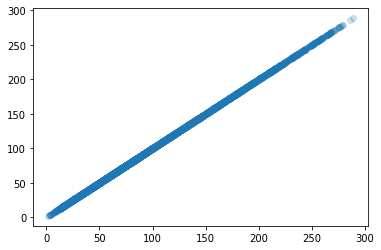

In [7]:
plt.scatter(x, _x, alpha=0.1)

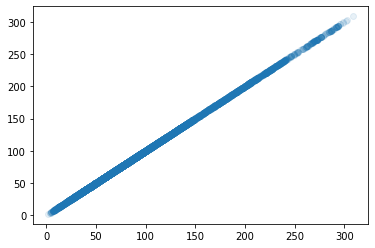

In [8]:
plt.scatter(y, _y, alpha=0.1)

In [10]:
(x - _x).sum()

0.0